Let explain what we aim to solve broadly. In this analysis we divided into fundamental analysis and technical analysis.
- Fundamental analysis involve analyzing company's future profitability based on its current business environment and financial performance.
- Technical analysis on the the other hand includes reading the charts and using statistical figures to identify the trend in the stock market.

So our focus will be on the technical analysis part.

Dataset explanation:
- The Open and Close represent the starting and final price at which the stock is traded on a particular day.
- High, Low and Last represent the maximum, minimum, and last price of the share for the day.
- 
Another thing to consider is the trading opens at 9:00 a.m. and closes at 3:30 p.m (6hour30min). 
The market is open every day of the week except Saturday, Sunday, and holidays

The profit or loss calculation is usually determined by the closing price of ta stock for the day, so we will
use the 'close' (closing_price) as the target variable.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
df = pd.read_csv('../data/korean_stock_data.csv')

In [4]:
# Rename columns
df.columns = ['open', 'high', 'low', 'close', 'volume', 'shares', 'company', 'date']
df.head(5)

,open,high,low,close,volume,shares,company,date
0,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-03
1,10720.0,10960.0,10480.0,10960.0,81165.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-04
2,10880.0,11120.0,10320.0,11120.0,66320.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-07
3,11120.0,11180.0,10940.0,11040.0,42455.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-08
4,10920.0,11060.0,10780.0,11060.0,43205.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-09


In [5]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.head(5)

,open,high,low,close,volume,shares,company
date,,,,,,,
2008-01-03,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd"
2008-01-04,10720.0,10960.0,10480.0,10960.0,81165.0,5586294,"Dongwha Pharm.Co.,Ltd"
2008-01-07,10880.0,11120.0,10320.0,11120.0,66320.0,5586294,"Dongwha Pharm.Co.,Ltd"
2008-01-08,11120.0,11180.0,10940.0,11040.0,42455.0,5586294,"Dongwha Pharm.Co.,Ltd"
2008-01-09,10920.0,11060.0,10780.0,11060.0,43205.0,5586294,"Dongwha Pharm.Co.,Ltd"


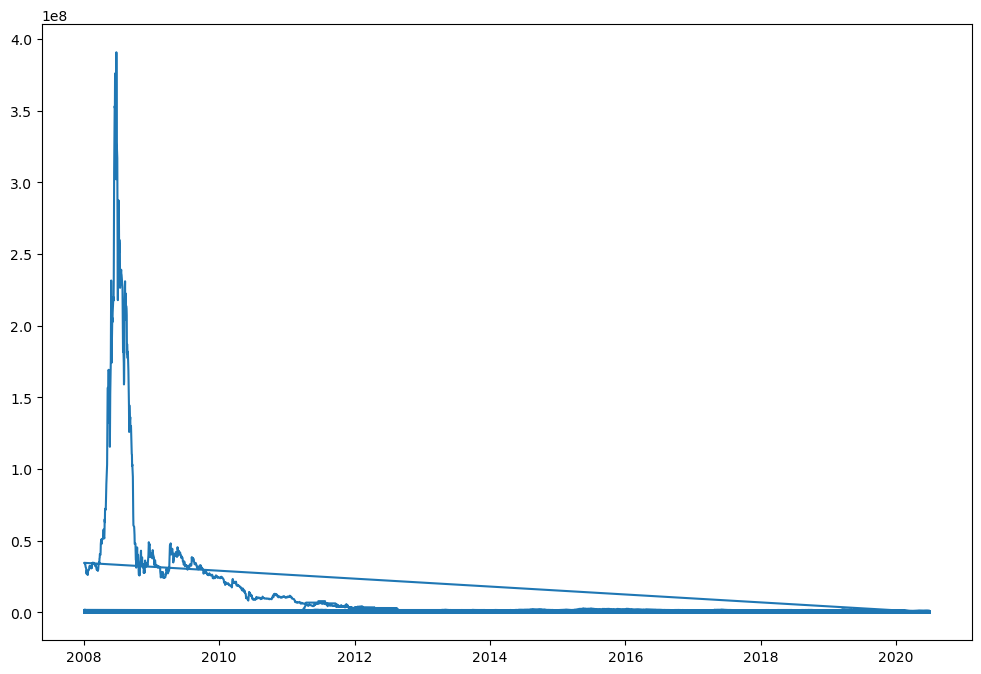

In [13]:
plt.figure(figsize=(12,8))
plt.plot(df['close'], label="Close Price History")

Moving Average
We will try to determine overall performance 

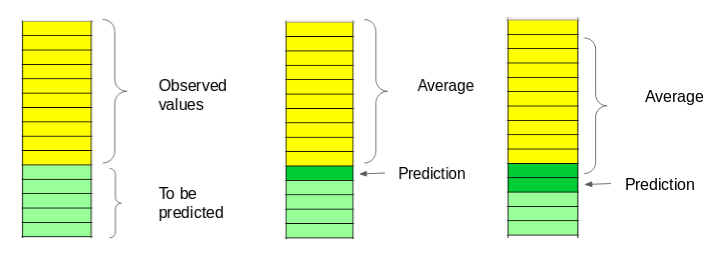 

### Step 1: Create a dataframe contain only 'close' and 'date' price columns, then split int inot train and val set to verify our predictions.

In [15]:
total_rows = len(df)

print(total_rows)

1048575


NOTE: While splitting the data into train and validation set, we cannot 
use random splitting since that will destroy the time component. So here we 
have set the last year’s data into validation and the 4 years’ data before that into train set.


Step-by-step process:
- Sort the data by date to ensure that it is in chronological order
- Determine the last year of data for the val set
- Split data val set (last year), train set (4y)


In [57]:
# remove duplicates in the index first since we set 'date' to the index
new_data = new_data.loc[~new_data.index.duplicated(keep='first')]

# Set 1 year before the latest date
latest_date = new_data.index.max()   
start_date_valid = latest_date - pd.DateOffset(years=1)

train_end_index = new_data.index[new_data.index < start_date_valid][-1]  

train = new_data[:train_end_index]
valid = new_data.loc[train_end_index + pd.Timedelta(days=1):]

print('\nShape of training set:')
print(train.shape)

print('\nShape of validation set:')
print(valid.shape)


Shape of training set:
(2841, 10)

Shape of validation set:
(248, 10)


Let's check the RMSE of the val set.

But first let's determine the look-back period of how much we should use to predict the next day
- Look-back window: 30-50 Days 

In [64]:
look_back = 30 

preds = []
for j in range(0, valid.shape[0]):
    a = train['close'][len(train) - look_back + j:].sum() + sum(preds)
    b = a/look_back
    preds.append(b)
    
rms = np.sqrt(np.mean(np.power((np.array(valid['close']) - preds), 2)))
print('\nRMSE value on validation set:')
print(rms)


RMSE value on validation set:
2979965.6456105947


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9492\3075031605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


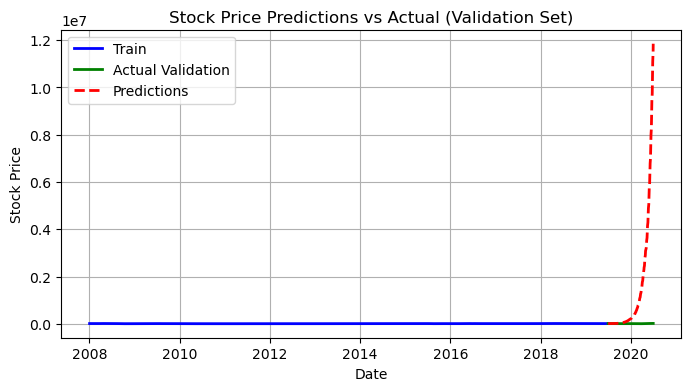

In [71]:
valid['Predictions'] = preds

plt.figure(figsize=(8,4)) 
plt.plot(train.index, train['close'], label='Train', color='blue', linewidth=2)
plt.plot(valid.index, valid['close'], label='Actual Validation', color='green', linewidth=2)
plt.plot(valid.index, valid['Predictions'], label='Predictions', color='red', linestyle='--', linewidth=2)

plt.title('Stock Price Predictions vs Actual (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.legend()

plt.grid(True)
plt.show()

Implement a Linear Regression model to see the relationship between independent and dependent variables.

The code below wil create features such as:
- year
- month
- week
- day
- weekday
- is_month_end
- is_month_start
- is_quarter_end
- is_quarter_start
- is_year_end
- is_year_start

Additional feature shall be add accordingly. Such as the first the last day of the week could affect the stock's closing price far more than the other days. So, we wil create feature that identifies whether a given day is Monday/Friday, Tuesday/Wednesday/Thursday, and except weekend and holiday.

In [72]:
new_data = pd.DataFrame({'date': data['date'].values, 'close': data['close'].values})

new_data['year'] = new_data['date'].dt.year
new_data['month'] = new_data['date'].dt.month
new_data['day'] = new_data['date'].dt.day
new_data['weekday'] = new_data['date'].dt.weekday
new_data['is_month_end'] = new_data['date'].dt.is_month_end
new_data['is_month_start'] = new_data['date'].dt.is_month_start
new_data['is_quarter_end'] = new_data['date'].dt.is_quarter_end
new_data['is_quarter_start'] = new_data['date'].dt.is_quarter_start
new_data['is_year_end'] = new_data['date'].dt.is_year_end
new_data['is_year_start'] = new_data['date'].dt.is_year_start

new_data.drop('date', axis=1, inplace=True)

if 'Elapsed' in new_data.columns:
    new_data.drop('Elapsed', axis=1, inplace=True)

# NOTE: if the day of the week is equal to 0 or 4, the col value will be 1; otherwise, it will be 0 
new_data['mon_fri'] = new_data['weekday'].apply(lambda x: 1 if x == 0 or x == 4 else 0)

In [81]:
# Ensure 'train_end_index' is the timestamp in the 'date' column, not the index
train_end_index_pos = new_data[new_data['date'] == train_end_index].index[0] if train_end_index in new_data['date'].values else None

if train_end_index_pos is not None:
    # Split the data into train and validation sets using .iloc (positional indexing)
    train = new_data.iloc[:train_end_index_pos + 1]
    valid = new_data.iloc[train_end_index_pos + 1:]

    # Prepare the training and validation sets
    x_train = train.drop('close', axis=1)
    y_train = train['close']
    x_valid = valid.drop('close', axis=1)
    y_valid = valid['close']

    # Linear regression model
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict using the model
    predictions = model.predict(x_valid)
else:
    print("Error: 'train_end_index' is not found in the 'date' column of the DataFrame.")


KeyError: 'date'

In [ ]:
# make prediction and find the rmse
preds = model.pred(x_valid)
rms = np.sqrt(np.mean(np.power((np.array(y_valid) - np.array(preds)),2)))
rms

In [ ]:
valid['Predictions'] = 0
valid['Predictions'] = preds

train.index = new_data[:train_end_index +1].index
valid.index = new_data[train_end_index +1:].index

plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

# Inference 

The problem we are facing is the regression algorithm can overfits the data and month column. So instead of taking into account the previous values from the point of prediction. The model will consider the value from the same date a month ago or the saem date/month a year ago. Therefore, in here we are looking for the independent variables that could be useful for determining the target value.

To find the potential target variable we will introduce the KNN algorithm.

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV 

In [ ]:
# we will use the same train and validation set from last section
# scaling data 
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# using gridsearch to find the best parameter 
params = {'n_neighbors' :[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# fit the model and make preds
model.fit(x_train, y_train)
preds= model.predict(x_valid)

In [ ]:
# evaluation
rms = np.sqrt(np.mean(np.power(np.array(y_valid)-np.array(preds)),2))
rms

In [ ]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['close', 'Predictions']])
plt.plot(train['close'])

Auto ARIMA is a statistical method for time seriees forecasting, it takes into account the past values to predict the future values. There are three important paarameters in ARIMA:
- p : past value used for forecasting the next level
- q : past forecast errors used to predict the future values
- d : order of differencing

Ref:
- ARIMA for Time Series Forecasting: A Complete Guide: https://www.datacamp.com/tutorial/arima?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=157156375671&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=684592140413&utm_targetid=aud-1940143831083:dsa-2218886984580&utm_loc_interest_ms=&utm_loc_physical_ms=1030757&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-apac_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&gad_source=1&gclid=CjwKCAiAzba9BhBhEiwA7glbagRjFymdE4FNEQY5fA4CFyFXky2KgSmtud644MPkQieci9IoSOB7OhoCwiYQAvD_BwE 
- Build high performance Time Series Models using Auto ARIMA in python and R: https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

In [ ]:
# inference
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:train_end_index+1]
valid = data[train_end_index+1:]

training = train['close']
validation = valid['close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

In [ ]:
from fbprophet import Prophet

# creating new dataframe
new_data = pd.DataFrame(index=range(0, len(df)), columns=['date', 'close'])

for j in range(0, len(data)):
    new_data['date'][j] = data['date'][j]
    new_data['close'][j] = data['close'][j]

# setting index
new_data.index = new_data.Date 

Feature Engineering 
- Latest Announcement of companies
- Quarterly Revenue Results
- Total Trade Quantity is the number of shares bought or sold in the day and Turnover (lacs) is the turn over of the particular company on a given date